# Earthquake_real
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA, eigenvalue deposition]

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium
from IPython.display import HTML

In [186]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [187]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2000"').reset_index().iloc[:,1:]
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8744 entries, 0 to 8743
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8744 non-null   object 
 1   Latitude   8744 non-null   float64
 2   Longitude  8744 non-null   float64
 3   Magnitude  8744 non-null   float64
 4   Year       8744 non-null   object 
dtypes: float64(3), object(2)
memory usage: 341.7+ KB


<AxesSubplot:>

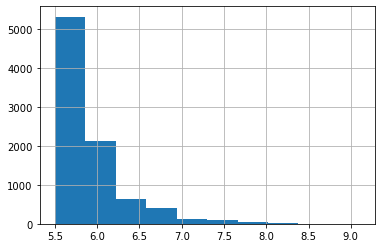

In [23]:
_df.Magnitude.hist()

##### 2. $f(x) = y$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [24]:
f = _df.loc[:,"Magnitude"]

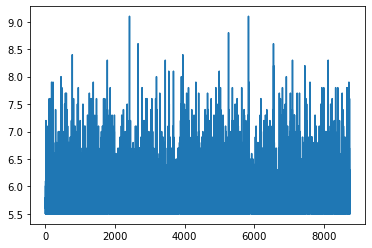

In [25]:
#collapse
plt.plot(f,'-')

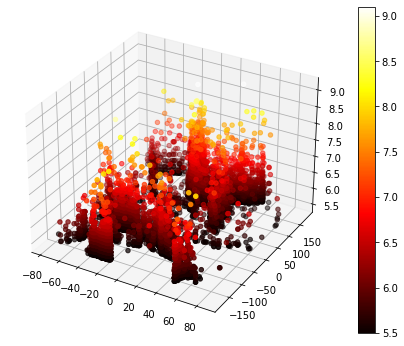

In [27]:
#collapse
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude, c= _df.Magnitude,  cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [28]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-2000)]

In [29]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [30]:
#collapse
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(2000,2016))).add_to(m)
m

##### 3. 비유클리드 공간에서의 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
- 지진의 영향이 주변에만 끼치는 것을 고려하여 경도, 위도의 차이가 90도 이내인 경우만 거리 계산

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2+(y_j-y_i)^2}$$
$$\text{if } (x_j - x_i) \gt 90 \text{ and } \text{ } (y_j - y_i) \gt 90$$

In [188]:
def dist(i,j):
    if abs( _df.Latitude[j] - _df.Latitude[i] ) > 90: 
        return 10000  
    elif abs( _df.Longitude[j] - _df.Longitude[i] ) > 90: 
        return 10000
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

##### 4. 거리를 이용한 a weighted adjacency matrix $W_{i,j}$ 정의

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [189]:
def weight(i,j,theta=150,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [194]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

(array([4.2284642e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.1600000e+02, 5.4826600e+05,
        7.2334020e+06, 2.6391010e+07]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

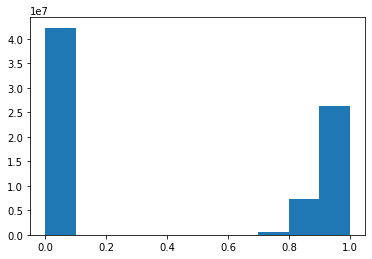

In [195]:
#collapse
plt.hist(W.reshape(-1))

그래프(임의보행 random walk)

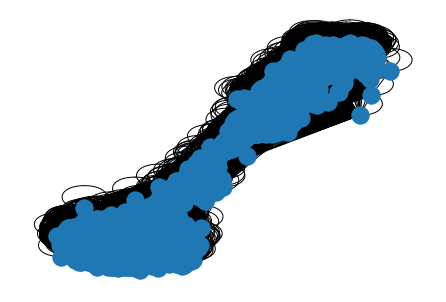

In [177]:
nx.draw(nx.Graph(W))
# 저장하고 싶으면
# plt.show(
# plt.savefig("networkGraph.png")

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [36]:
D = np.diag(W.sum(axis=1))

In [37]:
D

array([[3490.9134361 ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        , 1783.14978455,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        , 1582.43548691, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 4829.48599096,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        5070.23988759,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 4819.27276215]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [38]:
L = D - W

In [39]:
L

array([[ 3.48991344e+03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -9.17030275e-01,  0.00000000e+00],
       [ 0.00000000e+00,  1.78214978e+03, -8.98356231e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.98356231e-01,  1.58143549e+03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.82848599e+03, -9.44181666e-01, -9.99973372e-01],
       [-9.17030275e-01,  0.00000000e+00,  0.00000000e+00, ...,
        -9.44181666e-01,  5.06923989e+03, -9.42335310e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.99973372e-01, -9.42335310e-01,  4.81827276e+03]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [40]:
λ, Ψ = np.linalg.eig(L)

In [41]:
Λ = np.diag(λ)

In [204]:
λ[0:20].round(3)

array([  -0.   ,   44.962,  698.037,  879.952,  891.986,  884.921,
        886.987,  983.406,  987.144,  991.654, 1000.049, 1035.996,
       1048.147, 1054.358, 1071.038, 1063.062, 1061.737, 1059.138,
       1058.526, 1058.733])

##### 8. 주성분 분석
- $compk = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, 8000$
- $p = \sum_{1}^{n} comp1^2,\sum_{1}^{n} comp2^2,…,\sum_{1}^{n} compn^2$
- $p = \frac{p}{\sum(p)}$

In [42]:
def comp(i):
    return (f @ np.outer( Ψ[:,i], Ψ[:,i]))

In [43]:
def p(i):
    return sum(comp(i)**2)

In [44]:
array_1 = np.array([p(i) for i in range(1,len(_df))])

In [45]:
varprop = array_1/array_1.sum()

In [46]:
#collapse
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

In [47]:
#collapse_output
_indexlst

[6152,
 3016,
 2178,
 5227,
 7571,
 5896,
 836,
 6818,
 6856,
 2337,
 6239,
 4957,
 3934,
 7573,
 3324,
 6618,
 6628,
 2494,
 857,
 6619,
 6813,
 1077,
 7292,
 4088,
 7948]

(0.0, 40.0)

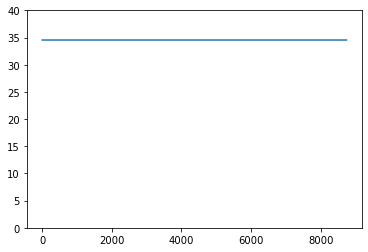

In [48]:
plt.plot( (f @ np.outer( Ψ[:,0], Ψ[:,0]))**2)
plt.ylim(0,40)

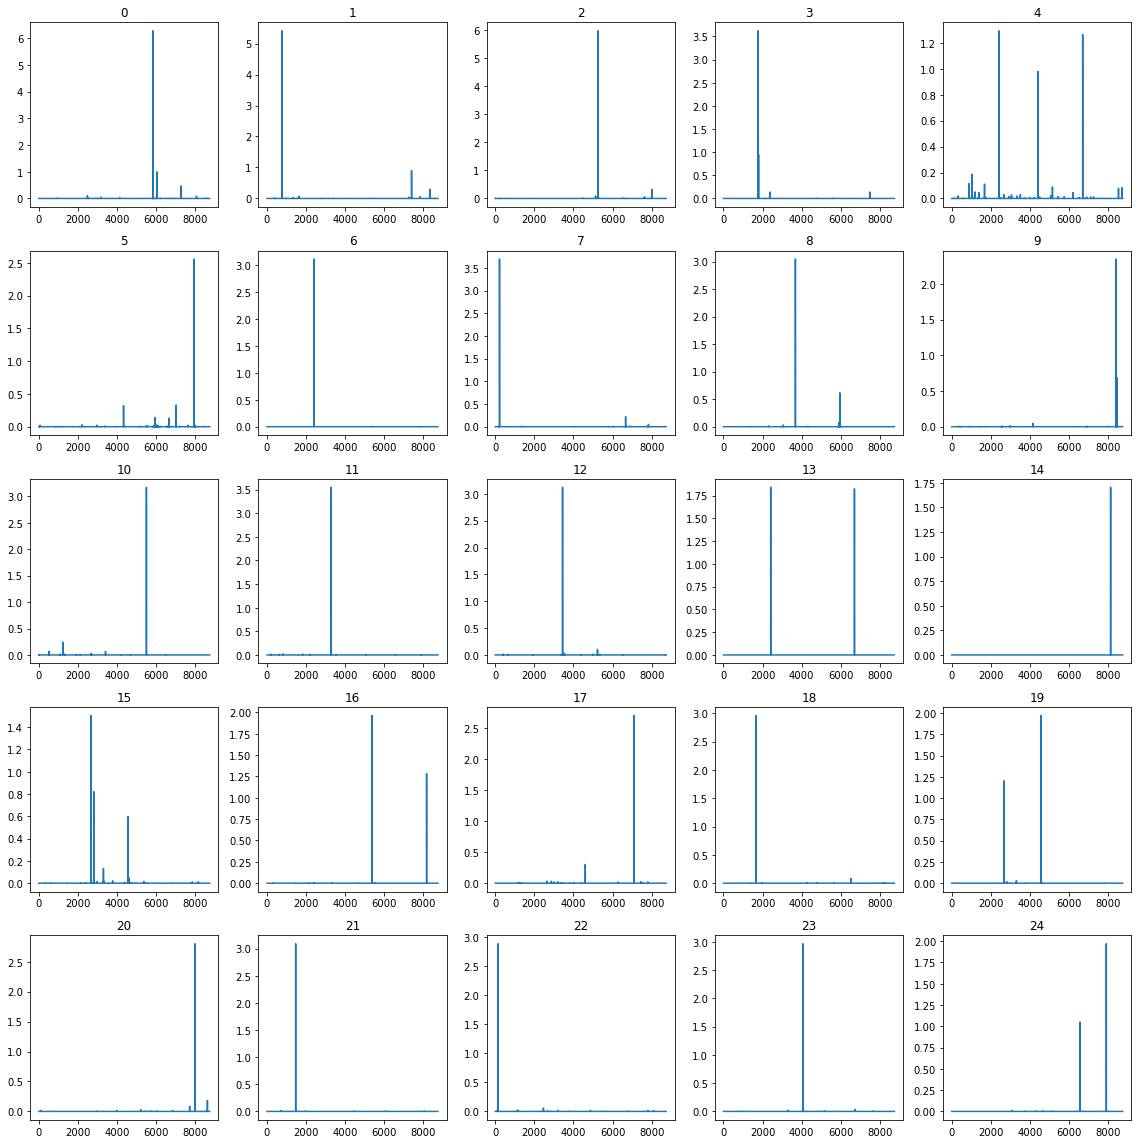

In [49]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,_indexlst[k]], Ψ[:,_indexlst[k]]))**2)
        # ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

##### 9. PCA

In [368]:
comp1 = f @ np.outer( Ψ[:,0], Ψ[:,0])

In [369]:
comp2 = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])

In [370]:
comp3 = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])

In [371]:
comp4 = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])

In [372]:
comp5 = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])

In [373]:
comp6 = f @ np.outer( Ψ[:,_indexlst[4]], Ψ[:,_indexlst[4]])

In [374]:
_df["comp1"] = comp1

In [375]:
_df["comp2"] = comp2

In [376]:
_df["comp3"] = comp3

In [377]:
_df["comp4"] = comp4

In [378]:
_df["comp5"] = comp5

In [379]:
_df["comp6"] = comp6

In [380]:
_df["compall"] = comp1 + comp2 +comp3 + comp4 + comp5 + comp6

In [381]:
_df["compall2"] = comp2 +comp3 + comp4 + comp5 + comp6

In [382]:
#collapse
_lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-2000)]

In [383]:
#collapse
__lst1=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,5]].\
to_numpy().tolist() for i in range(2016-2000)]

In [384]:
#collapse
__lst2=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,6]].\
to_numpy().tolist() for i in range(2016-2000)]

In [385]:
#collapse
__lst3=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,7]].\
to_numpy().tolist() for i in range(2016-2000)]

In [386]:
#collapse
__lst4=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,8]].\
to_numpy().tolist() for i in range(2016-2000)]

In [387]:
#collapse
__lst5=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,9]].\
to_numpy().tolist() for i in range(2016-2000)]

In [388]:
#collapse
__lst6=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,10]].\
to_numpy().tolist() for i in range(2016-2000)]

In [389]:
#collapse
__lstall=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,11]].\
to_numpy().tolist() for i in range(2016-2000)]

In [390]:
#collapse
__lstall2=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,12]].\
to_numpy().tolist() for i in range(2016-2000)]

In [67]:
#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [73]:
#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst2,radius=50,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

---

- 남태평양 (37.1557 144.6611, 37.3370 144.2370, 38.5060 141.9000, -7.7270 159.4750, 37.9300 143.8020, 37.9140 143.7640, 37.1057 144.6715, 37.9380 143.5990)
- 솔로몬해 (-9.3290 159.1673) 남서태평양 부근

In [157]:
_df.sort_values("comp2")[-10:-1]

Date  Latitude  Longitude  Magnitude  Year     comp1     comp2  \
5202  01/17/2010   37.9380   143.5990        5.6  2010  5.877395  0.080330   
7269  10/25/2013   37.1057   144.6715        5.5  2013  5.877395  0.081572   
6863  12/07/2012   37.9140   143.7640        6.2  2012  5.877395  0.091564   
5847  03/11/2011   37.9300   143.8020        6.3  2011  5.877395  0.107747   
8589  09/14/2016   -9.3290   159.1673        6.0  2016  5.877395  0.119531   
2540  01/22/2005   -7.7270   159.4750        6.4  2005  5.877395  0.120563   
3018  12/16/2005   38.5060   141.9000        6.0  2005  5.877395  0.123177   
5863  03/11/2011   37.3370   144.2370        6.1  2011  5.877395  0.143002   
7267  10/25/2013   37.1557   144.6611        7.1  2013  5.877395  0.685526   

         comp3     comp4     comp5     comp6  
5202  0.000017 -0.000039 -0.000390  0.000062  
7269  0.000017 -0.000039 -0.000364  0.000068  
6863  0.000017 -0.000039 -0.000392  0.000063  
5847  0.000017 -0.000039 -0.000392  0.000063  
8589  0.000019 -0.000038 -0.000063  0.000086  
2540  0.000019 -0.000038 -0.000025  0.000091  
3018  0.000017 -0.000039 -0.000428  0.000049  
5863  0.000017 -0.000039 -0.000384  0.000065  
7267  0.000017 -0.000039 -0.000378  0.000068

---

In [74]:
#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst3,radius=50,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

---

- 남대서양 (14.6682 -58.9272)
- 브라질 (-7.6060 -71.7220, -8.2950 -71.7380)
- 카리브 해 (10.9048 -62.3150, 11.1240 -62.5590) 브라질 위
- 볼리비아 (-19.2592 -63.9189)
- 콜롬비아 (4.3300 -73.7640)
- 콜롬비아 위쪽 부근 (7.0420 -77.8290)
- 베네수엘라 (10.4540 -63.4750)

In [158]:
_df.sort_values("comp3")[-10:-1]

Date  Latitude  Longitude  Magnitude  Year     comp1     comp2  \
5200  01/15/2010   10.4540   -63.4750        5.6  2010  5.877395 -0.000006   
431   11/08/2000    7.0420   -77.8290        6.5  2000  5.877395 -0.000003   
4346  05/24/2008    4.3300   -73.7640        5.9  2008  5.877395 -0.000004   
7370  01/27/2014  -19.2592   -63.9189        5.6  2014  5.877395 -0.000005   
371   10/04/2000   11.1240   -62.5590        6.2  2000  5.877395 -0.000006   
1342  10/12/2002   -8.2950   -71.7380        6.9  2002  5.877395 -0.000004   
7251  10/12/2013   10.9048   -62.3150        6.0  2013  5.877395 -0.000006   
1639  06/20/2003   -7.6060   -71.7220        7.1  2003  5.877395 -0.000004   
7393  02/18/2014   14.6682   -58.9272        6.5  2014  5.877395 -0.000006   

         comp3     comp4         comp5         comp6  
5200  0.068093 -0.004054 -9.902094e-07  9.178107e-06  
431   0.086172 -0.001590 -4.565092e-07 -1.454736e-06  
4346  0.091330 -0.001757 -5.569279e-07  2.799644e-07  
7370  0.126530 -0.003673 -8.966770e-07  8.048556e-06  
371   0.130404 -0.003128 -1.046387e-06  1.054049e-05  
1342  0.166766 -0.001707 -5.638365e-07  3.726622e-07  
7251  0.210905 -0.002979 -1.051451e-06  1.068778e-05  
1639  0.266692 -0.001724 -5.638442e-07  3.748997e-07  
7393  0.948964 -0.003036 -1.228123e-06  1.586936e-05

---

In [75]:
#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst4,radius=50,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

---

- 카롱가 말라위 (-10.126 33.870, -10.108 33.818)
- 남태평양 (56.594 -156.430, -36.129 -73.257, 58.235 -151.221, -36.217 -73.257)
- 칠레 (-36.074 -70.570)
- 미국 알레스카 코디악 섬 (57.369 -154.206, 57.401 -154.269)

In [159]:
_df.sort_values("comp4")[-10:-1]

Date  Latitude  Longitude  Magnitude  Year     comp1  \
245   07/11/2000    57.401   -154.269        5.5  2000  5.877395   
5345  03/16/2010   -36.217    -73.257        6.7  2010  5.877395   
1957  01/20/2004    58.235   -151.221        5.5  2004  5.877395   
5152  12/19/2009   -10.108     33.818        6.0  2009  5.877395   
244   07/11/2000    57.369   -154.206        6.6  2000  5.877395   
6646  06/07/2012   -36.074    -70.570        6.0  2012  5.877395   
5286  02/27/2010   -36.129    -73.257        5.5  2010  5.877395   
7993  05/29/2015    56.594   -156.430        6.7  2015  5.877395   
5132  12/06/2009   -10.126     33.870        5.8  2009  5.877395   

             comp2     comp3     comp4         comp5         comp6  
245   8.287029e-07  0.002763  0.063033  1.075998e-07  2.027612e-07  
5345 -3.243943e-06 -0.000569  0.063623 -4.518802e-07  1.700581e-07  
1957  8.796409e-07  0.002008  0.067790  1.172173e-07  1.138469e-07  
5152  6.098090e-05  0.002925  0.081454  2.222834e-05 -7.870314e-04  
244   8.322470e-07  0.003037  0.086612  1.081114e-07  2.014678e-07  
6646 -3.280917e-06 -0.000873  0.098309 -4.720510e-07  5.258293e-07  
5286 -3.245256e-06 -0.000531  0.141829 -4.520672e-07  1.703117e-07  
7993  8.117625e-07  0.001272  0.215134  1.043589e-07  2.337824e-07  
5132  6.088868e-05  0.002950  0.296198  2.224737e-05 -7.809752e-04

---

In [76]:
#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst5,radius=50,index=list(range(2000,2016))).add_to(_m)
_m

---

- 남태평양 (41.7150 144.0490, 42.3430 143.7640, 41.8070 144.2310, 41.8630 144.2090, 42.1590 144.0040)
- 코랄해 (-11.2397 161.8756, -11.1090 161.9150)
- 일본 (42.3950 142.9580, 42.4190 142.9130)

In [160]:
_df.sort_values("comp5")[-10:-1]

Date  Latitude  Longitude  Magnitude  Year     comp1     comp2  \
3655  03/18/2007   42.1590   144.0040        5.5  2007  5.877395 -0.002861   
2046  03/26/2004   41.8630   144.2090        5.8  2004  5.877395 -0.002826   
1782  09/25/2003   41.8070   144.2310        5.5  2003  5.877395 -0.002838   
1779  09/25/2003   42.3430   143.7640        5.5  2003  5.877395 -0.002912   
2349  11/11/2004  -11.1090   161.9150        5.5  2004  5.877395 -0.003910   
6734  08/25/2012   42.4190   142.9130        5.9  2012  5.877395 -0.003042   
2149  06/10/2004   42.3950   142.9580        5.8  2004  5.877395 -0.003045   
7493  04/14/2014  -11.2397   161.8756        5.8  2014  5.877395 -0.003892   
2361  11/14/2004   41.7150   144.0490        5.5  2004  5.877395 -0.002968   

         comp3     comp4     comp5     comp6  
3655  0.000017 -0.000039  0.015418  0.000058  
2046  0.000018 -0.000039  0.015873  0.000059  
1782  0.000018 -0.000039  0.017358  0.000059  
1779  0.000017 -0.000039  0.018660  0.000056  
2349  0.000020 -0.000037  0.031188  0.000083  
6734  0.000017 -0.000039  0.067206  0.000051  
2149  0.000017 -0.000039  0.074431  0.000051  
7493  0.000020 -0.000037  0.089764  0.000083  
2361  0.000017 -0.000039  0.191433  0.000058

---

In [167]:
#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst6,radius=50,index=list(range(2000,2016))).add_to(_m)
_m

---

- 인도네시아 (2.7070 96.0450, 2.6750 96.0620, -8.1935 117.8136, -4.0610 121.6940)
- 인도양 (3.5330 95.6580, -11.3750 115.0420)
- 말라카 (5.2834 96.1678) 알레스카, 미국
- 필리핀 (7.5930 124.0220)
- 셀레베스 해 (3.7330 124.6840) 인도네시아 필리핀 사이

In [162]:
_df.sort_values("comp6")[-10:-1]

Date  Latitude  Longitude  Magnitude  Year     comp1     comp2  \
3509  12/12/2006    3.7330   124.6840        6.3  2006  5.877395  0.000300   
6206  07/11/2011   -4.0610   121.6940        5.5  2011  5.877395  0.000246   
1190  06/14/2002    7.5930   124.0220        5.6  2002  5.877395  0.000333   
8529  07/31/2016   -8.1935   117.8136        5.6  2016  5.877395  0.000241   
8698  12/06/2016    5.2834    96.1678        6.5  2016  5.877395  0.000409   
5151  12/19/2009    2.6750    96.0620        5.5  2009  5.877395  0.000389   
887   09/20/2001  -11.3750   115.0420        5.6  2001  5.877395  0.000236   
1033  01/24/2002    3.5330    95.6580        5.7  2002  5.877395  0.000397   
6698  07/25/2012    2.7070    96.0450        6.4  2012  5.877395  0.000390   

             comp3     comp4     comp5     comp6  
3509 -9.462553e-06 -0.000041 -0.000053  0.173008  
6206  6.047089e-07  0.000014 -0.000071  0.213636  
1190 -8.566473e-06 -0.000043 -0.000043  0.224372  
8529 -6.365248e-06  0.000019 -0.000076  0.279446  
8698  3.648001e-06  0.000043 -0.000041  0.287317  
5151  3.583999e-06  0.000043 -0.000047  0.298019  
887  -1.214039e-05  0.000023 -0.000081  0.338343  
1033  3.140678e-06  0.000043 -0.000045  0.432146  
6698  3.582331e-06  0.000043 -0.000047  1.123773

---

##### **Survey_Graph Signal Processing(fig1)**

In [174]:
#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lstall,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [176]:
#collapse
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lstall2,radius=50,index=list(range(2000,2016))).add_to(_m)
_m

---

In [458]:
_df

Date  Latitude  Longitude  Magnitude  Year     comp1  \
0     01/01/2000  -60.7220   153.6700        6.0  2000  5.877395   
1     01/02/2000  -17.9430  -178.4760        5.5  2000  5.877395   
2     01/02/2000   51.4470  -175.5580        5.8  2000  5.877395   
3     01/02/2000  -20.7710  -174.2360        5.8  2000  5.877395   
4     01/05/2000  -20.9640  -174.0970        5.6  2000  5.877395   
...          ...       ...        ...        ...   ...       ...   
8739  12/28/2016   38.3917  -118.8941        5.6  2016  5.877395   
8740  12/28/2016   38.3777  -118.8957        5.5  2016  5.877395   
8741  12/28/2016   36.9179   140.4262        5.9  2016  5.877395   
8742  12/29/2016   -9.0283   118.6639        6.3  2016  5.877395   
8743  12/30/2016   37.3973   141.4103        5.5  2016  5.877395   

             comp2     comp3     comp4         comp5         comp6   compall  \
0     4.664731e-04  0.000025 -0.000048  3.468068e-04  8.819439e-06  5.878194   
1     6.412047e-08  0.000037 -0.000162 -2.833078e-09  2.342977e-07  5.877270   
2     1.572105e-07  0.000005  0.000159  1.094847e-08  2.378566e-07  5.877560   
3     1.520335e-07  0.000010 -0.000092  7.129268e-09  2.997602e-07  5.877313   
4     1.582828e-07  0.000005 -0.000079  7.864700e-09  3.045607e-07  5.877321   
...            ...       ...       ...           ...           ...       ...   
8739  1.669351e-06  0.000296  0.000141  2.861388e-07 -6.332746e-07  5.877833   
8740  1.669442e-06  0.000296  0.000141  2.861535e-07 -6.332953e-07  5.877833   
8741  3.036409e-03  0.000017 -0.000039 -2.151491e-04  3.693664e-05  5.880231   
8742  2.398799e-04 -0.000005  0.000018 -7.956415e-05 -5.932190e-03  5.871636   
8743  4.358575e-03  0.000017 -0.000039 -2.596991e-04  4.556624e-05  5.881517   

      compall2  
0     0.000799  
1    -0.000125  
2     0.000165  
3    -0.000082  
4    -0.000074  
...        ...  
8739  0.000439  
8740  0.000439  
8741  0.002836  
8742 -0.005759  
8743  0.004122  

[8744 rows x 13 columns]

In [448]:
_G = nx.Graph(W-np.identity(len(f)))

In [449]:
_pos = nx.spring_layout(_G,iterations=20)

In [450]:
m_pos = list(zip(_df.Latitude,_df.Longitude))

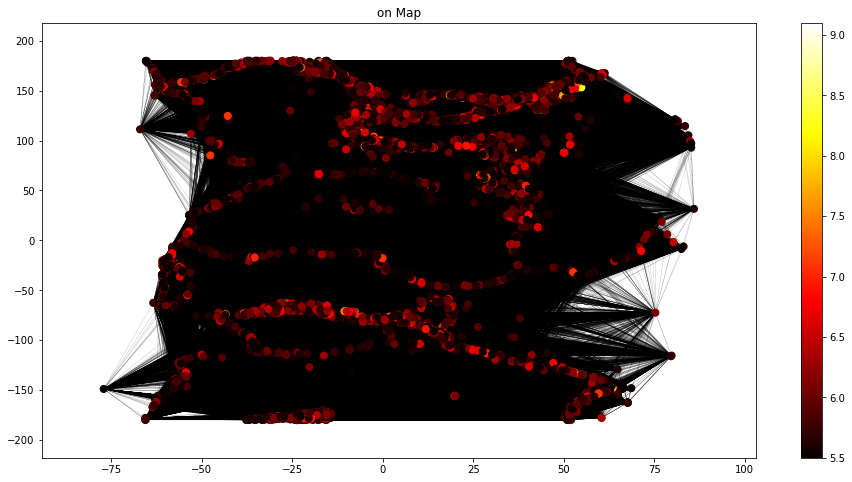

In [452]:
fig,ax = plt.subplots(figsize = (16,8))
plt.title('on Map')
nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.Magnitude,node_size = 50, ax=ax)
edges = nx.draw_networkx_edges(_G,m_pos,edge_color='k' ,width=0.1, edge_cmap=plt.cm.Blues,ax=ax)
plt.colorbar(nodes)
plt.axis()
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

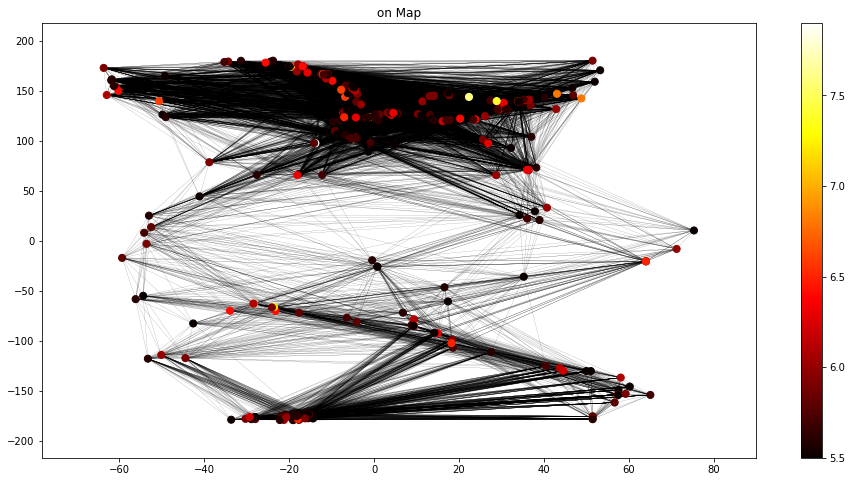

In [441]:
#collapse
fig,ax = plt.subplots(figsize = (16,8))
plt.title('on Map')
nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.Magnitude[:300],node_size = 50, ax=ax)
edges = nx.draw_networkx_edges(_G,m_pos,edge_color='k' ,width=0.1, edge_cmap=plt.cm.Blues,ax=ax)
plt.colorbar(nodes)
plt.axis()
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

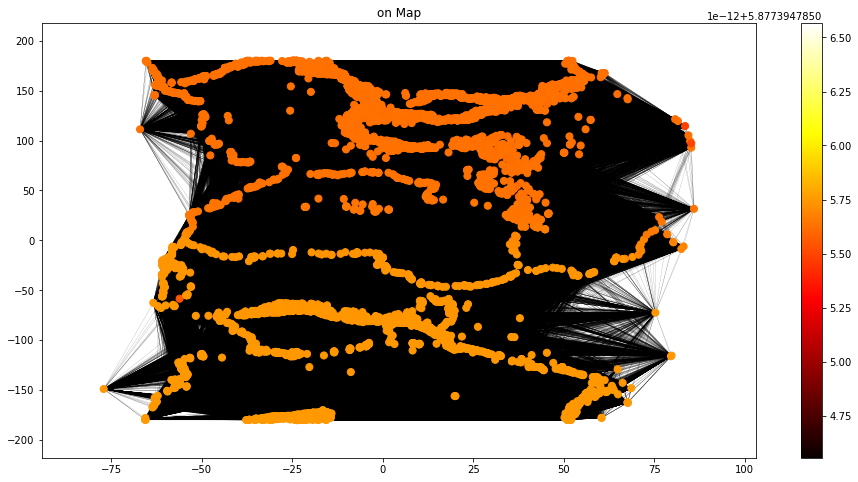

In [453]:
#collapse
fig,ax = plt.subplots(figsize = (16,8))
plt.title('on Map')
nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = 50, ax=ax)
edges = nx.draw_networkx_edges(_G,m_pos,edge_color='k' ,width=0.1, edge_cmap=plt.cm.Blues,ax=ax)
plt.colorbar(nodes)
plt.axis()
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

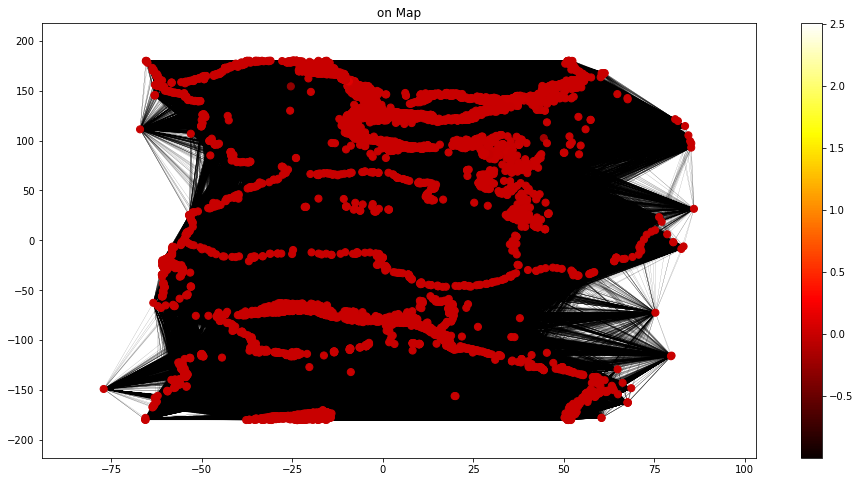

In [454]:
#collapse
fig,ax = plt.subplots(figsize = (16,8))
plt.title('on Map')
nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = 50, ax=ax)
edges = nx.draw_networkx_edges(_G,m_pos,edge_color='k' ,width=0.1, edge_cmap=plt.cm.Blues,ax=ax)
plt.colorbar(nodes)
plt.axis()
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

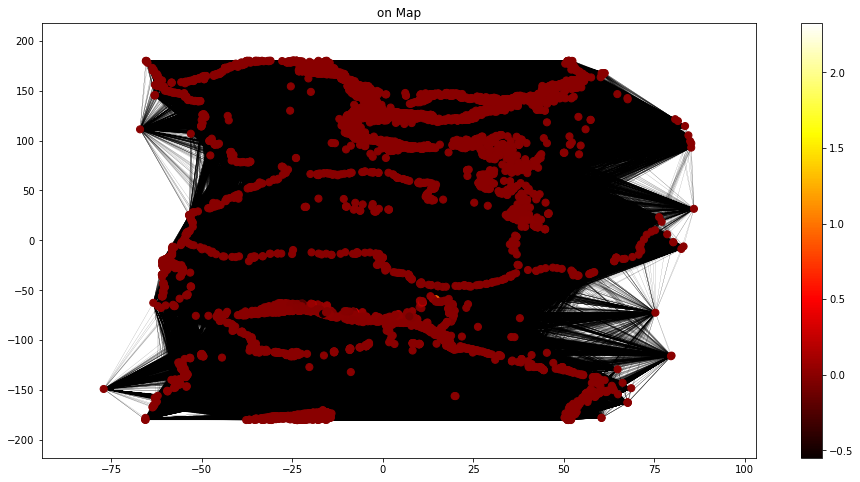

In [455]:
#collapse
fig,ax = plt.subplots(figsize = (16,8))
plt.title('on Map')
nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = 50, ax=ax)
edges = nx.draw_networkx_edges(_G,m_pos,edge_color='k' ,width=0.1, edge_cmap=plt.cm.Blues,ax=ax)
plt.colorbar(nodes)
plt.axis()
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

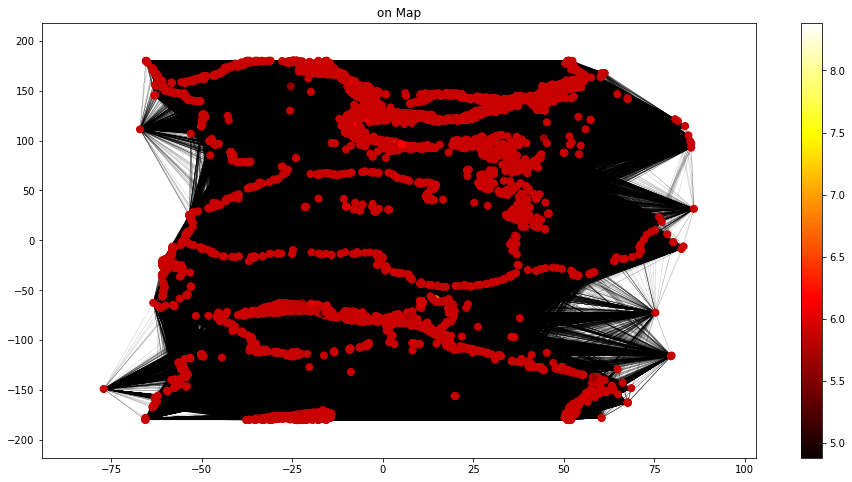

In [456]:
#collapse
fig,ax = plt.subplots(figsize = (16,8))
plt.title('on Map')
nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.compall,node_size = 50, ax=ax)
edges = nx.draw_networkx_edges(_G,m_pos,edge_color='k' ,width=0.1, edge_cmap=plt.cm.Blues,ax=ax)
plt.colorbar(nodes)
plt.axis()
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

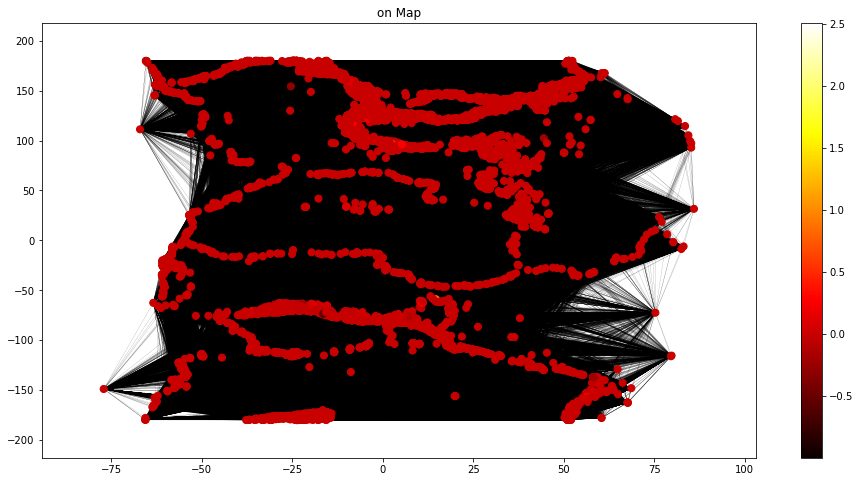

In [457]:
#collapse
fig,ax = plt.subplots(figsize = (16,8))
plt.title('on Map')
nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.compall2,node_size = 50, ax=ax)
edges = nx.draw_networkx_edges(_G,m_pos,edge_color='k' ,width=0.1, edge_cmap=plt.cm.Blues,ax=ax)
plt.colorbar(nodes)
plt.axis()
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

---